# Statistical analysis comparing PEA software test set and flight data

Ref: https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339


This provides information on the sampling and comparison of acquisition failure
statistics to flight data for two simulated datasets:

- ASVT: `PeaAcqModelCalDec2022Testing`
- SWATS: (s/w test set) https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339

Sinces the SWATS data are undersampled in key regions, the acquisition failure 
comparison is done with the combination of ASVT and SWATS data. The SWATS data dominates
in most bins where there is substantial flight data.

## Summary

There is reasonable agreement between the simulated acquisition statistics and flight.
However, in some bins there is disagreement that is statistically significant. In most
cases of disagreement the simulated acquisition failure rate **exceeds** flight, meaning
that it is **conservative** to use the simulated data for acquisition probability
modeling.


In [1]:
import sys

sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")

import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from astropy.table import Table, vstack
from cxotime import CxoTime

from utils_stats import (
    AcqBins,
    ValsBins,
    flatten_pea_test_data,
    get_acq_stats_data,
    get_samples_successes,
    pformat_sampling,
    plot_diff_pmf,
    read_twiki_csv,
)

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
# Original sampling for ASVT data for reference
# mag_vals = (8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75)
# t_ccd_vals = (-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2)

mag_vals = (8.25, 9, 9.5, 10, 10.5)
t_ccd_vals = (-13, -11, -9, -7, -5, -3)

acq_bins = AcqBins(mag=ValsBins(mag_vals), t_ccd=ValsBins(t_ccd_vals))

### Get flight data

In [3]:
flt_all = get_acq_stats_data("2022:001")

### Get ASVT data from Dec 2022

In [4]:
topic = "PeaAcqModelCalDec2022Testing/"
name = "pea_analysis_2022_336_AcqProbModel_calibration_test_results.csv"
asvt8 = read_twiki_csv(topic + name)
asvt = flatten_pea_test_data(asvt8)
asvt = asvt["ccd_temp", "star_mag", "search_box_hw", "search_success", "slot"]
asvt.info

<Table length=22464>
     name       dtype 
-------------- -------
      ccd_temp   int64
      star_mag float64
 search_box_hw   int64
search_success   int64
          slot   int64

### Get SWATS data

In [5]:
# Large dataset with flight-like sampling but expanded temperatures
fn = "PEA_SW_TS_Acq_results_2024_08_27_w_more flight_like_maxmag.csv"
# Flight-like sampling
fn = "PEA_SW_TS_Acq_results_2024_09_11_flight_recreation.csv"
swats8 = Table.read(fn, format="ascii.csv")
swats = flatten_pea_test_data(swats8)
swats.rename_column("Mag_sim_info", "star_mag")
# Some bright stars around 1.0 mag
swats = swats[swats["star_mag"] > 4.0]
swats = swats[
    "ccd_temp", "star_mag", "search_box_hw", "search_success", "slot", "ObsID"
]
swats.info

<Table length=22999>
     name       dtype 
-------------- -------
      ccd_temp float64
      star_mag float64
 search_box_hw   int64
search_success   int64
          slot   int64
         ObsID   int64

### Summary of sampling

This is the number of acquisition samples in each bin.

In [6]:
def match_datasets(dat1, dat2):
    """Match datasets by ObsID and slot"""
    keys1 = [f"{row['ObsID']}_{row['slot']}" for row in dat1]
    keys2 = [f"{row['ObsID']}_{row['slot']}" for row in dat2]
    keys12 = list(set(keys1) & set(keys2))
    ok1 = np.in1d(keys1, keys12)
    ok2 = np.in1d(keys2, keys12)
    dat1 = dat1[ok1]
    dat2 = dat2[ok2]
    dat1.sort(["ObsID", "slot"])
    dat2.sort(["ObsID", "slot"])
    return dat1, dat2

In [7]:
flt_all_match, swats_match = match_datasets(flt_all, swats)
print(len(flt_all), len(swats))
print(len(flt_all_match), len(swats_match))

43470 22999
20272 20272


In [8]:
# OPTIONALLY use only the matched datasets
# flt_all = flt_all_match
# swats = swats_match

In [9]:
CxoTime(np.min(flt_all["tstart"])).date, CxoTime(np.max(flt_all["tstart"])).date

('2022:001:05:49:45.222', '2024:254:05:57:56.944')

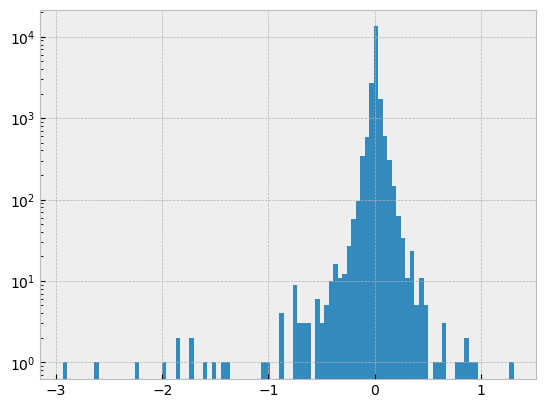

In [10]:
plt.hist(flt_all_match["star_mag"] - swats_match["star_mag"], bins=100, log=True);

In [11]:
flt_lines = pformat_sampling(flt_all, acq_bins, add_mag=True)
asvt_lines = pformat_sampling(asvt, acq_bins, add_mag=False)
swats_lines = pformat_sampling(swats, acq_bins, add_mag=False)
_summary = Table(
    [flt_lines, asvt_lines, swats_lines], names=["Flight", "ASVT", "SWATS"]
)
_summary.pprint_all()

               Flight                                ASVT                               SWATS               
------------------------------------ ----------------------------------- -----------------------------------
                       Halfwidth 60:                       Halfwidth 60:                       Halfwidth 60:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ----
8.25     3     3   13   13    3    2   |    36    36   36   72   72   72   |     3     1    2   15    1    0
   9     6    64  221  217   59    2   |    36    36   36   72   72   72   |     2    53  154  219   37    0
 9.5    41   112  139  185  142   11   |    36    36   36   72   72   72   |    26    75   64  131   71    3
  10    19   111  219  273  162    9   |    72    72   72  144  144  144   |    11    73  140  216  101    2
10.5    25   119  1

### Overview of coverage in CCD temperature, magnitude, and halfwidth for SWATS data

Text(0.5, 0, 'CCD Temperature (C)')

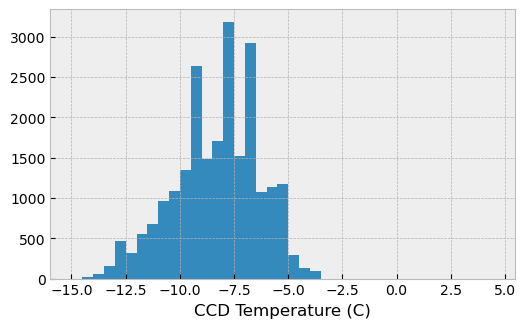

In [12]:
plt.figure(figsize=(6, 3.5))
plt.hist(swats["ccd_temp"], bins=np.arange(-15, 5, 0.5))
plt.xlabel("CCD Temperature (C)")

Text(0, 0.5, 'Star Magnitude')

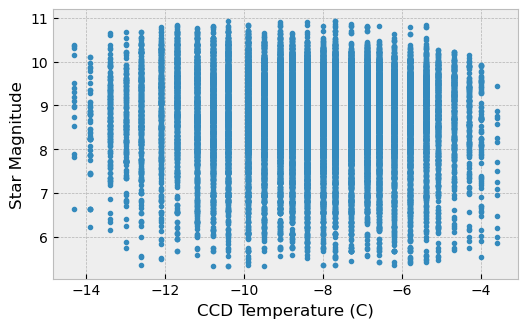

In [13]:
plt.figure(figsize=(6, 3.5))
plt.plot(swats["ccd_temp"], swats["star_mag"], ".")
plt.xlabel("CCD Temperature (C)")
plt.ylabel("Star Magnitude")

Text(0.5, 0, 'Search Box Half-Width')

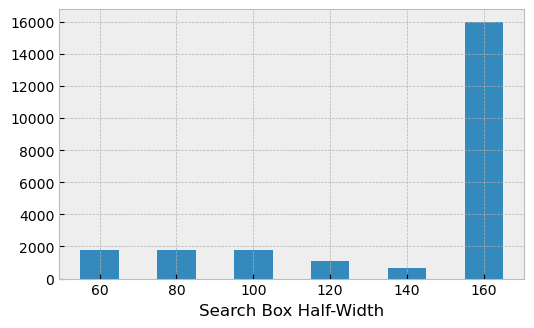

In [14]:
plt.figure(figsize=(6, 3.5))
plt.hist(swats["search_box_hw"], bins=np.arange(55, 175, 10))
plt.xlabel("Search Box Half-Width")

### Define simulated dataset as composite of ASVT and SWATS

In [15]:
# sim_all = vstack([asvt, swats])
sim_all = swats

### Get the number of acquisition samples and successes in the defined bins

In [16]:
n_samp_sim_all, n_succ_sim_all = get_samples_successes(sim_all, acq_bins)
n_samp_flt_all, n_succ_flt_all = get_samples_successes(flt_all, acq_bins)

## Compute CDF of difference between flight and PEA test set data

In [17]:
def plot_acq_failure_prob_distributions(halfwidth=60):
    print(f"Acq Failure Probability Distributions (halfwidth={halfwidth})")

    kk = list(acq_bins.halfwidth.vals).index(halfwidth)
    n_samp_asvt = n_samp_sim_all[:, :, kk]
    n_succ_asvt = n_succ_sim_all[:, :, kk]
    n_samp_flt = n_samp_flt_all[:, :, kk]
    n_succ_flt = n_succ_flt_all[:, :, kk]
    n_fail_flt = n_samp_flt - n_succ_flt
    n_fail_asvt = n_samp_asvt - n_succ_asvt

    ni, nj = n_samp_flt.shape

    sample_mask = (
        (n_samp_flt >= 30)
        & (n_samp_asvt >= 30)
        & (
            (n_fail_flt / n_samp_flt.clip(1) > 0.05)
            | (n_fail_asvt / n_samp_asvt.clip(1) > 0.05)
        )
    )
    # Truncate up to the nearest multiple of 2.
    n_row = int(np.ceil(np.count_nonzero(sample_mask) / 2))
    fig, axes = plt.subplots(n_row, 4, figsize=(12, 3 * n_row))

    i_plot = 0
    for ii in range(0, ni):
        for jj in range(nj):
            if not sample_mask[ii, jj]:
                continue

            k1 = n_fail_flt[ii, jj]
            n1 = n_samp_flt[ii, jj]
            k2 = n_fail_asvt[ii, jj]
            n2 = n_samp_asvt[ii, jj]

            title = f"mag={mag_vals[ii]} T_ccd={t_ccd_vals[jj]}"
            plot_diff_pmf(
                k1,
                n1,
                k2,
                n2,
                title,
                "Flight",
                "Sim",
                axes=axes.flat[i_plot : i_plot + 2],
            )
            i_plot += 2

    fig.tight_layout()


Acq Failure Probability Distributions (halfwidth=60)


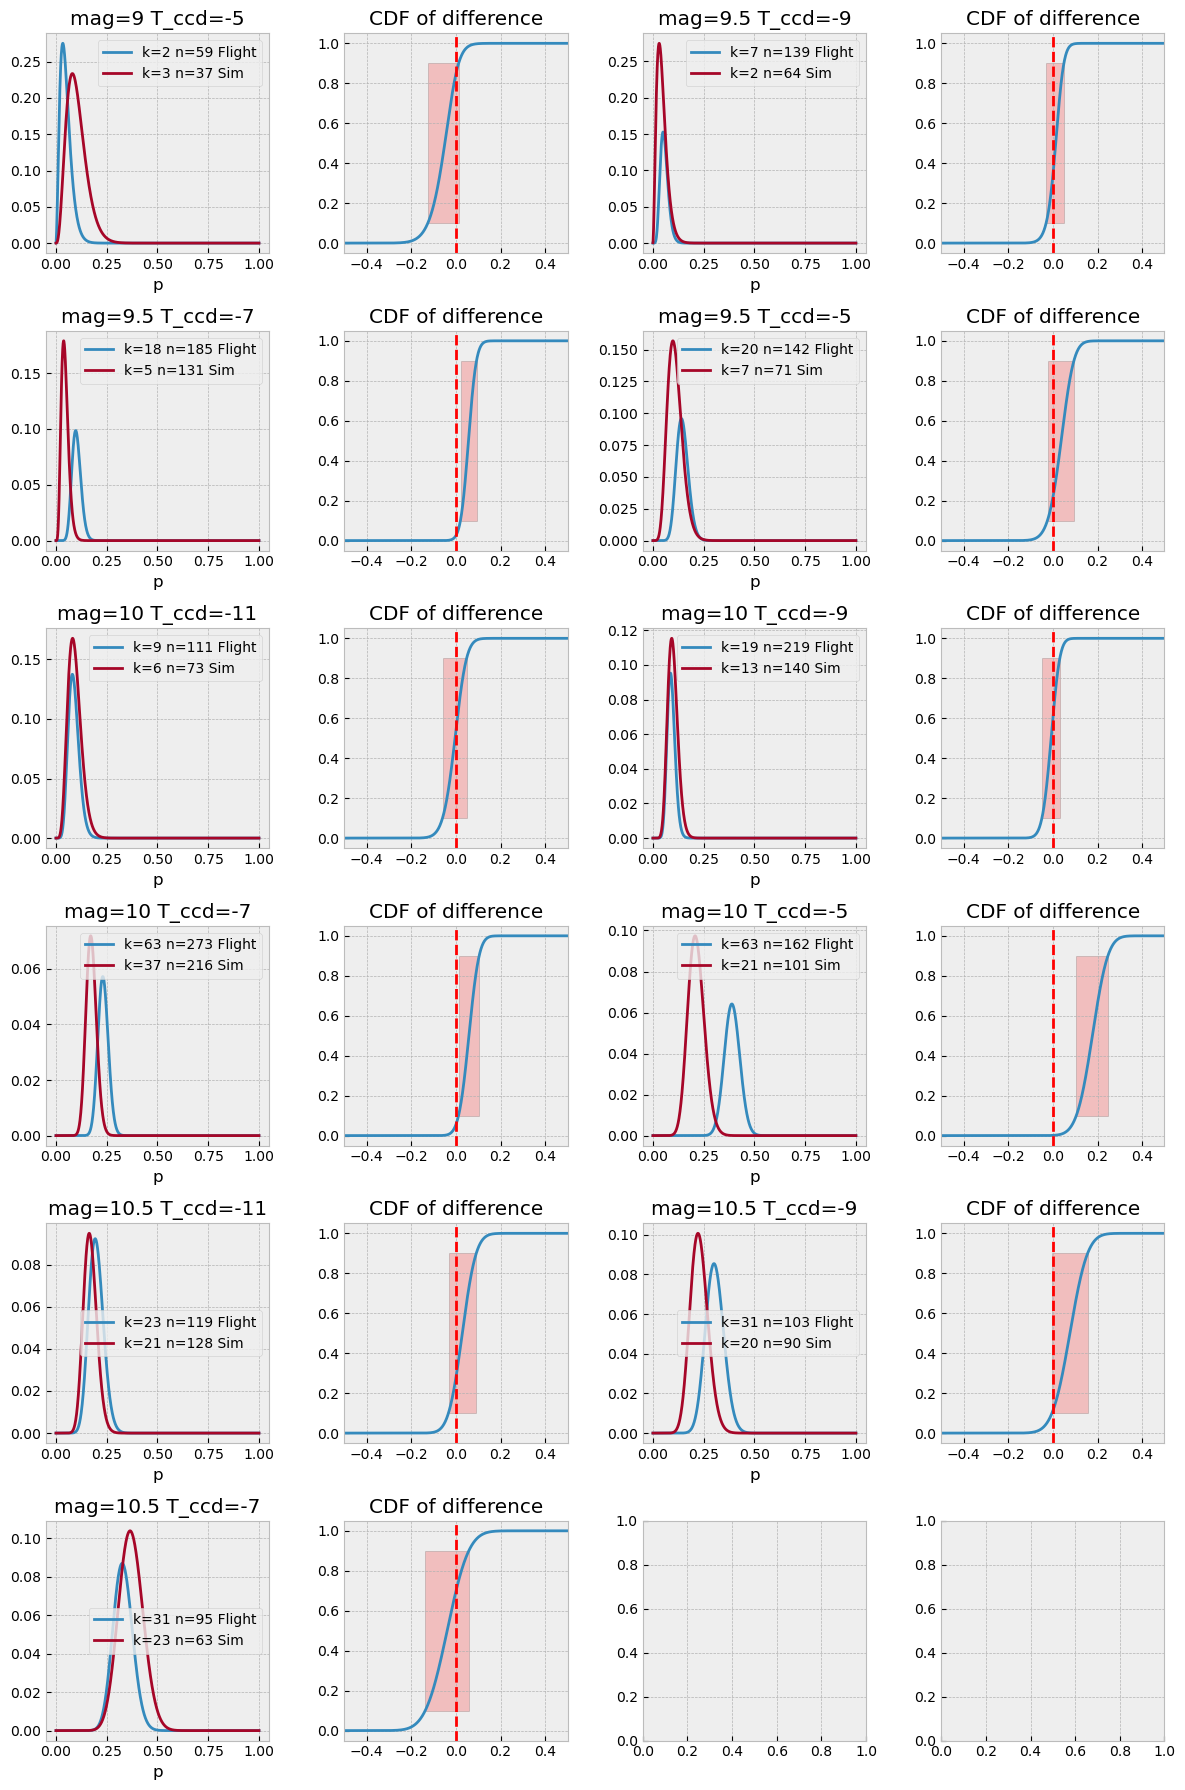

In [18]:
plot_acq_failure_prob_distributions(60)

Acq Failure Probability Distributions (halfwidth=80)


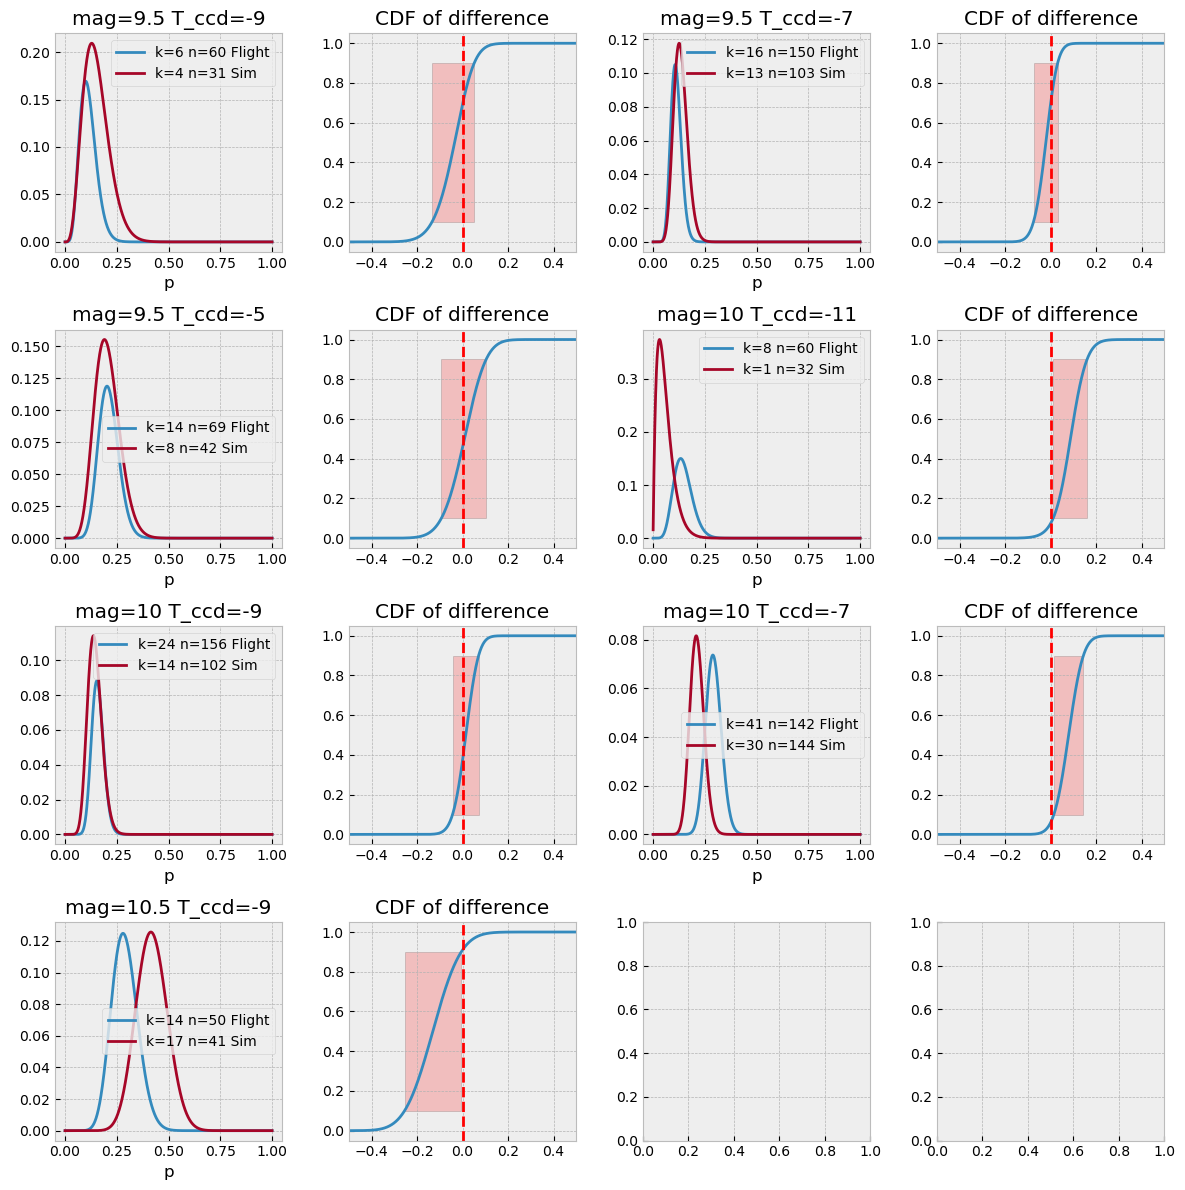

In [19]:
plot_acq_failure_prob_distributions(80)

Acq Failure Probability Distributions (halfwidth=100)


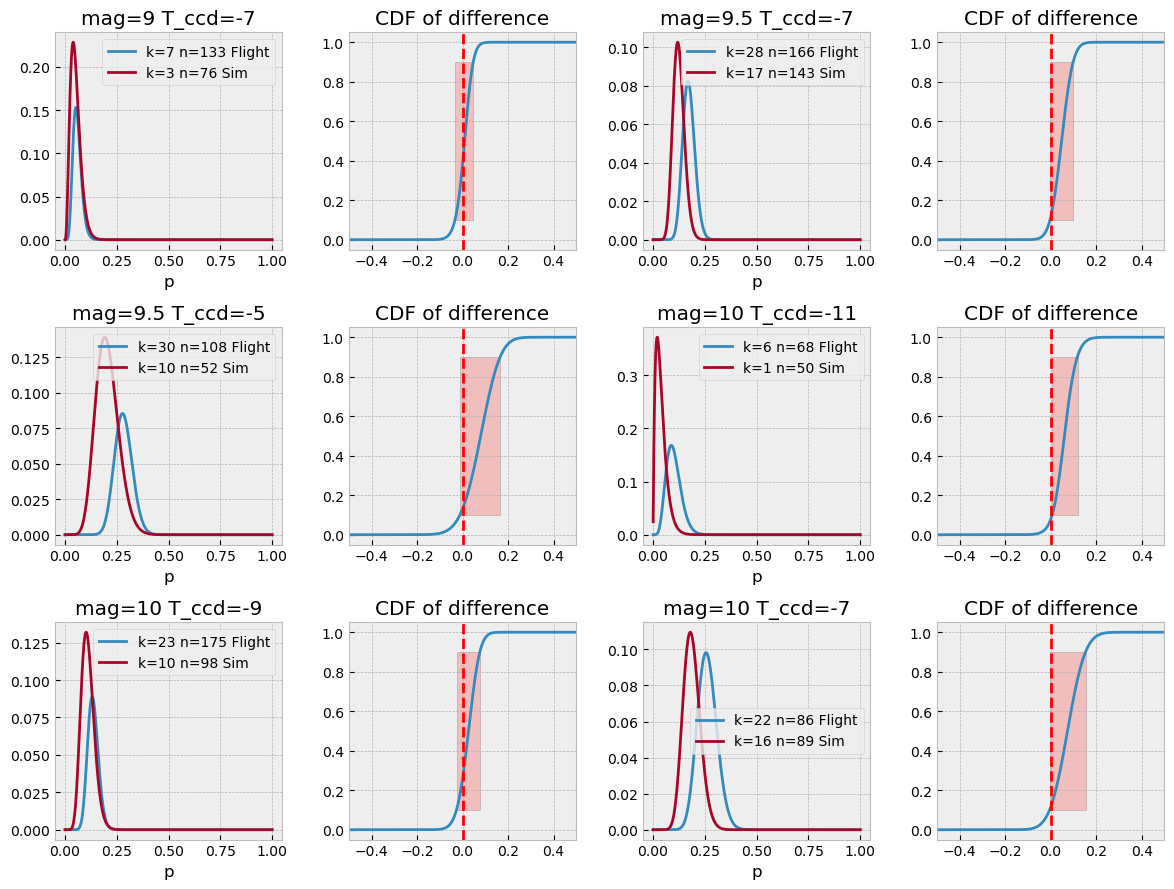

In [20]:
plot_acq_failure_prob_distributions(100)

Acq Failure Probability Distributions (halfwidth=120)


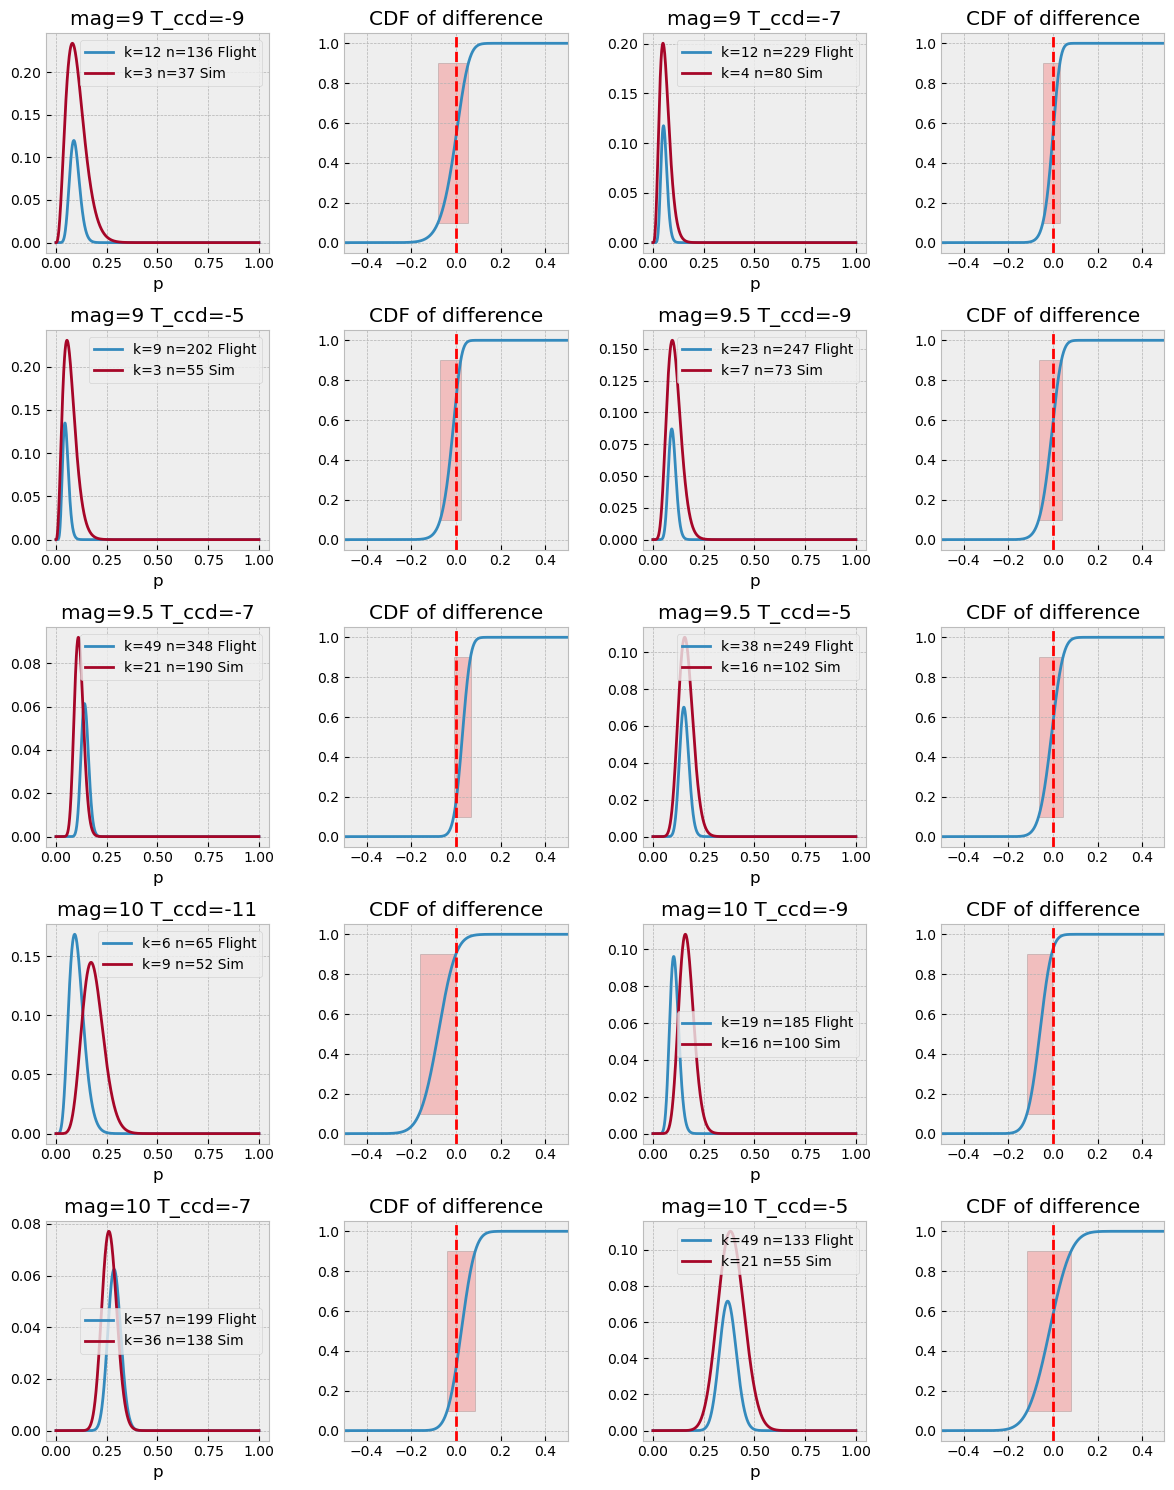

In [21]:
plot_acq_failure_prob_distributions(120)

Acq Failure Probability Distributions (halfwidth=140)


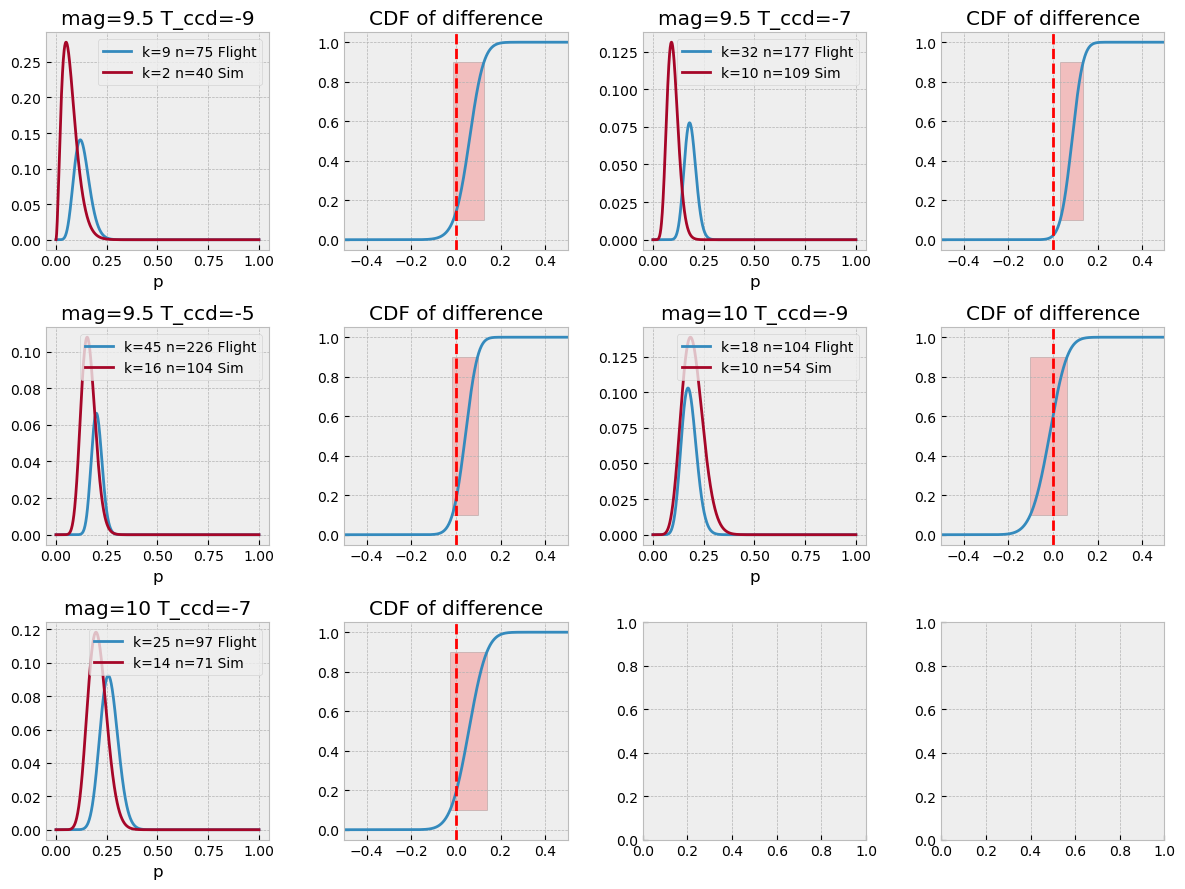

In [22]:
plot_acq_failure_prob_distributions(140)

Acq Failure Probability Distributions (halfwidth=160)


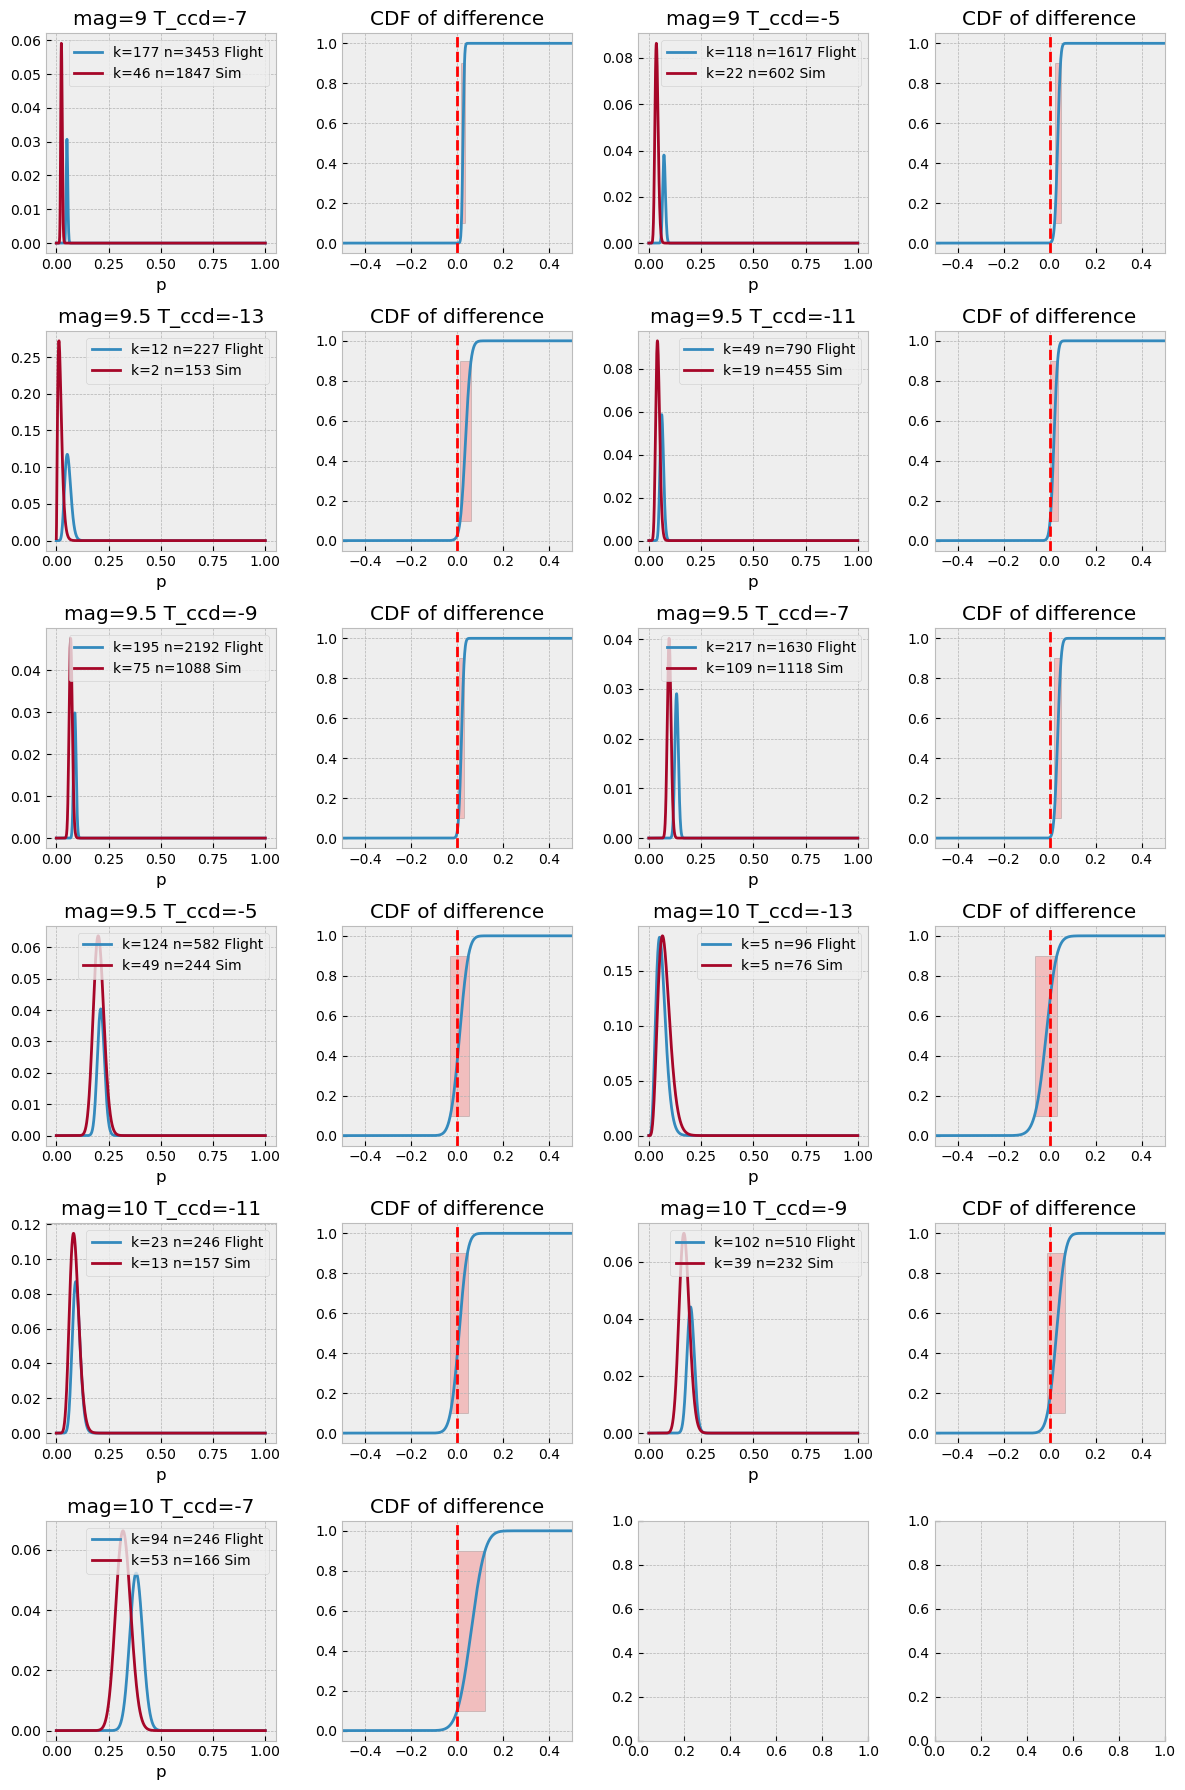

In [23]:
plot_acq_failure_prob_distributions(160)